# Outlier

‚úÖ Ï¥ù ÌîÑÎ†àÏûÑ Ïàò: 436


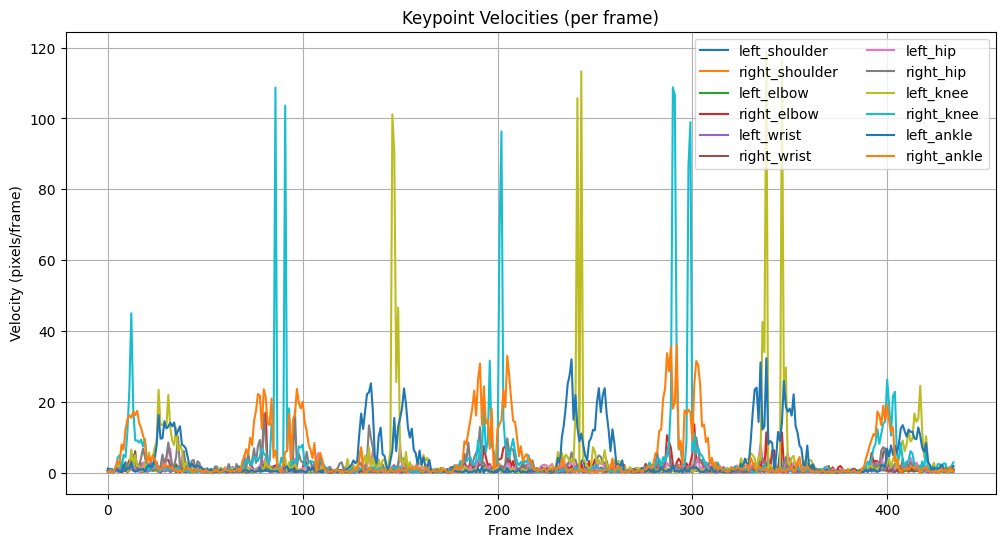

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from math import acos, degrees

# ---------------------- Í≤ΩÎ°ú ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/17_ÎàÑÏõåÏÑú Î≤àÍ∞àÏïÑ Îã§Î¶¨ Îì§Í∏∞_JSON"
)

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    """JSONÏóêÏÑú keypoints Ï¢åÌëúÎßå Î°úÎìú"""
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    """ÏÑ∏ Ï†ê ÏÇ¨Ïù¥ Í∞ÅÎèÑ Í≥ÑÏÇ∞"""
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)+1e-6)
    return degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- Ïù∏Îç±Ïä§ Ï†ïÏùò ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

# ---------------------- Îç∞Ïù¥ÌÑ∞ Ï†ÅÏû¨ ----------------------
all_keypoints = []
for json_file in sorted(KP_DIR.glob("*.json")):
    all_keypoints.append(load_keypoints(json_file))
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

print(f"‚úÖ Ï¥ù ÌîÑÎ†àÏûÑ Ïàò: {len(all_keypoints)}")

# ---------------------- Velocity Í≥ÑÏÇ∞ ----------------------
velocities = {}  # {keypoint_name: [velocity per frame]}

for name, idx in keypoint_indices.items():
    # ÌîÑÎ†àÏûÑ Í∞Ñ Ïù¥Îèô Í±∞Î¶¨ = velocity
    diffs = np.linalg.norm(np.diff(all_keypoints[:, idx, :], axis=0), axis=1)
    velocities[name] = diffs  # (n_frames-1,) ÌÅ¨Í∏∞

# ---------------------- ÏãúÍ∞ÅÌôî ----------------------
plt.figure(figsize=(12,6))

for name, vals in velocities.items():
    plt.plot(vals, label=name)

plt.title("Keypoint Velocities (per frame)")
plt.xlabel("Frame Index")
plt.ylabel("Velocity (pixels/frame)")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.show()


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm  # ÏßÑÌñâÎ•† ÌëúÏãú

# ---------------------- Í≤ΩÎ°ú ----------------------
FRAME_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/1_FRAME_OLD/sample_data/ward_sample_video/17_ÎàÑÏõåÏÑú Î≤àÍ∞àÏïÑ Îã§Î¶¨ Îì§Í∏∞_frames"
)

KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/17_ÎàÑÏõåÏÑú Î≤àÍ∞àÏïÑ Îã§Î¶¨ Îì§Í∏∞_JSON"
)

OUT_PATH = "skeleton_overlay_corrected.mp4"

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

# ---------------------- Ïù∏Îç±Ïä§ Ï†ïÏùò ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

bone_pairs = [
    ("left_shoulder","left_elbow"),
    ("left_elbow","left_wrist"),
    ("right_shoulder","right_elbow"),
    ("right_elbow","right_wrist"),
    ("left_hip","left_knee"),
    ("left_knee","left_ankle"),
    ("right_hip","right_knee"),
    ("right_knee","right_ankle"),
    ("left_shoulder","left_hip"),
    ("right_shoulder","right_hip"),
    ("left_shoulder","right_shoulder"),
    ("left_hip","right_hip")
]

# ---------------------- Îç∞Ïù¥ÌÑ∞ Ï†ÅÏû¨ ----------------------
all_keypoints = []
json_files = sorted(KP_DIR.glob("*.json"))
for json_file in tqdm(json_files, desc="Loading keypoints"):
    all_keypoints.append(load_keypoints(json_file))
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

print(f"‚úÖ Ï¥ù ÌîÑÎ†àÏûÑ Ïàò: {len(all_keypoints)}")

# ---------------------- Outlier Î≥¥Ï†ï ----------------------
def fix_outliers(all_keypoints, vel_thresh=40):
    """
    Ïù¥Ï†Ñ ÌîÑÎ†àÏûÑÍ≥º ÎπÑÍµêÌï¥ÏÑú threshold Ïù¥ÏÉÅ ÏõÄÏßÅÏù∏ keypointÎäî
    outlierÎ°ú Í∞ÑÏ£ºÌïòÍ≥† Ïù¥Ï†Ñ ÌîÑÎ†àÏûÑ Í∞íÏúºÎ°ú ÍµêÏ≤¥
    """
    corrected = all_keypoints.copy()

    for f in range(1, len(all_keypoints)):
        diffs = np.linalg.norm(corrected[f] - corrected[f-1], axis=1)
        for name, idx in keypoint_indices.items():
            if diffs[idx] > vel_thresh:
                corrected[f, idx] = corrected[f-1, idx]  # Ïù¥Ï†Ñ ÌîÑÎ†àÏûÑ Í∞íÏúºÎ°ú ÎçÆÏñ¥Ïì∞Í∏∞

    return corrected

all_keypoints_corrected = fix_outliers(all_keypoints, vel_thresh=60)

# ---------------------- Skeleton Overlay Video ----------------------
def save_skeleton_overlay_video(frame_dir, all_keypoints, out_path="skeleton_overlay_corrected.mp4", fps=30):
    frame_files = sorted(frame_dir.glob("*.jpg"))  # jpg ÌîÑÎ†àÏûÑ Í∞ÄÏ†ï
    if not frame_files:
        frame_files = sorted(frame_dir.glob("*.png"))  # png fallback

    # Ï≤´ ÌîÑÎ†àÏûÑ ÌÅ¨Í∏∞ ÌôïÏù∏
    sample_frame = cv2.imread(str(frame_files[0]))
    h, w, _ = sample_frame.shape
    size = (w, h)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, fps, size)

    for f, frame_file in enumerate(tqdm(frame_files, desc="Generating video")):
        frame_img = cv2.imread(str(frame_file))
        points = all_keypoints[f].astype(int)

        # skeleton Í∑∏Î¶¨Í∏∞
        for (a,b) in bone_pairs:
            ia, ib = keypoint_indices[a], keypoint_indices[b]
            cv2.line(frame_img,
                     (points[ia,0], points[ia,1]),
                     (points[ib,0], points[ib,1]),
                     (0,255,0), 2)

        # keypoints Í∑∏Î¶¨Í∏∞
        for (name, idx) in keypoint_indices.items():
            x,y = points[idx]
            cv2.circle(frame_img, (x,y), 4, (0,0,255), -1)

        writer.write(frame_img)

    writer.release()
    print(f"‚úÖ Î≥¥Ï†ïÎêú Skeleton overlay ÏòÅÏÉÅ Ï†ÄÏû• ÏôÑÎ£å: {out_path}")

# ---------------------- Ïã§Ìñâ ----------------------
save_skeleton_overlay_video(FRAME_DIR, all_keypoints_corrected, out_path=OUT_PATH, fps=30)


Loading keypoints: 100% 436/436 [00:00<00:00, 8220.24it/s]


‚úÖ Ï¥ù ÌîÑÎ†àÏûÑ Ïàò: 436


Generating video: 100% 436/436 [00:07<00:00, 58.62it/s]

‚úÖ Î≥¥Ï†ïÎêú Skeleton overlay ÏòÅÏÉÅ Ï†ÄÏû• ÏôÑÎ£å: skeleton_overlay_corrected.mp4


# ICP Outlier Detection

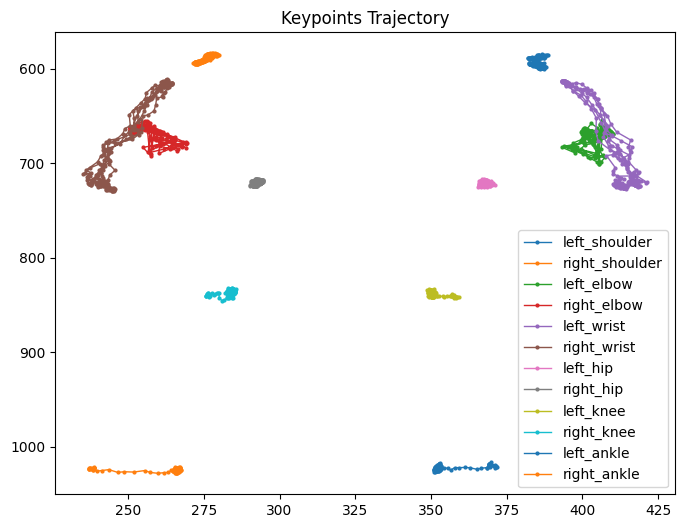

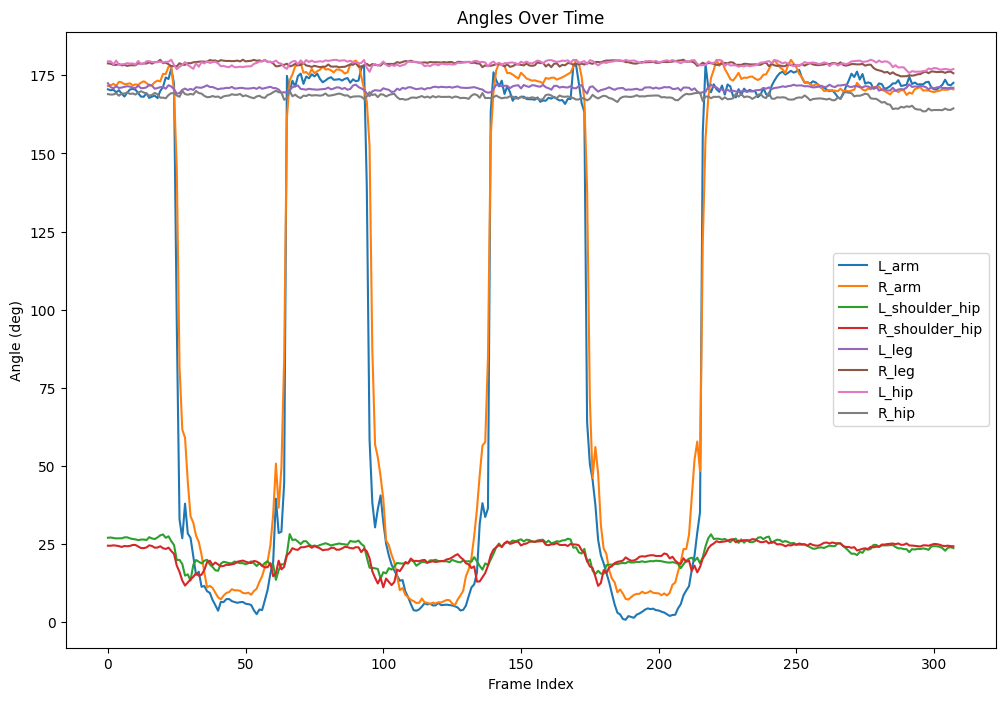

In [3]:
#!/usr/bin/env python  # ÌååÏù¥Ïç¨ Ïã§ÌñâÍ∏∞ ÏßÄÏ†ï
# -*- coding: utf-8 -*-  # UTF-8 Ïù∏ÏΩîÎî© ÏÇ¨Ïö©

# ---------------------- ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ----------------------
import json  # JSON ÌååÏùº ÏùΩÍ∏∞
from pathlib import Path  # Í≤ΩÎ°ú Í¥ÄÎ¶¨
import numpy as np  # ÏàòÏπò Í≥ÑÏÇ∞Ïö©
import matplotlib.pyplot as plt  # Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôîÏö©
from math import acos, degrees  # ÏΩîÏÇ¨Ïù∏ Î≤ïÏπôÏúºÎ°ú Í∞ÅÎèÑ Í≥ÑÏÇ∞
from sklearn.neighbors import NearestNeighbors  # ICP Îß§Ïπ≠Ïö©

# ---------------------- Í≤ΩÎ°ú ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_JSON"
)  # JSON ÌÇ§Ìè¨Ïù∏Ìä∏Í∞Ä Ï†ÄÏû•Îêú Ìè¥Îçî Í≤ΩÎ°ú

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    """JSONÏóêÏÑú keypoints Ï¢åÌëúÎßå Î°úÎìú"""
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # Ï≤´ Î≤àÏß∏ ÏÇ¨ÎûåÏùò keypoints (17Í∞ú, 2D Ï¢åÌëú)

def angle_between(p1, p2, p3):
    """ÏÑ∏ Ï†ê p1-p2-p3 ÏÇ¨Ïù¥Ïùò Í∞ÅÎèÑ(ÎèÑ Îã®ÏúÑ)"""
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- Ïù∏Îç±Ïä§ Ï†ïÏùò ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

# 8Í∞ú Í¥ÄÏ†àÍ∞Å Ï†ïÏùò
angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- Îç∞Ïù¥ÌÑ∞ Ï†ÅÏû¨ ----------------------
all_keypoints, all_angles = [], {k: [] for k in angles_def.keys()}

for json_file in sorted(KP_DIR.glob("*.json")):
    kp = load_keypoints(json_file)  # keypoints Î°úÎìú (17,2)
    all_keypoints.append(kp)
    for name, (i, j, k) in angles_def.items():
        all_angles[name].append(angle_between(kp[i], kp[j], kp[k]))

all_keypoints = np.array(all_keypoints)  # (frame, 17, 2)
for k in all_angles:
    all_angles[k] = np.array(all_angles[k])

# ---------------------- ICP Ìï®Ïàò ----------------------
def icp(source, target, max_iter=20):
    """
    source: (N,2), target: (N,2)
    Rigid transform ICP (translation + rotation)
    """
    src = source.copy()
    tgt = target.copy()

    for _ in range(max_iter):
        # ÏµúÍ∑ºÏ†ë Ï†ê Îß§Ïπ≠
        nbrs = NearestNeighbors(n_neighbors=1).fit(tgt)
        distances, indices = nbrs.kneighbors(src)
        matched_tgt = tgt[indices[:,0]]

        # ÌèâÍ∑† Ï†úÍ±∞
        mu_src, mu_tgt = np.mean(src, axis=0), np.mean(matched_tgt, axis=0)
        src_c, tgt_c = src - mu_src, matched_tgt - mu_tgt

        # SVDÎ°ú ÌöåÏ†Ñ Ï∂îÏ†ï
        H = src_c.T @ tgt_c
        U, _, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1,:] *= -1
            R = Vt.T @ U.T
        t = mu_tgt - R @ mu_src

        # Î≥ÄÌôò Ï†ÅÏö©
        src = (R @ src.T).T + t

    return src, distances[:,0]

# ---------------------- ÏãúÍ∞ÅÌôî ----------------------
# 1. Keypoints Í∂§Ï†Å
plt.figure(figsize=(8,6))
for name, idx in keypoint_indices.items():
    xs, ys = all_keypoints[:,idx,0], all_keypoints[:,idx,1]
    plt.plot(xs, ys, marker="o", markersize=2, linewidth=1, label=name)
plt.gca().invert_yaxis()
plt.legend()
plt.title("Keypoints Trajectory")
plt.show()

# 2. Í∞ÅÎèÑ ÏãúÍ≥ÑÏó¥
plt.figure(figsize=(12,8))
for name, vals in all_angles.items():
    plt.plot(vals, label=name)
plt.legend()
plt.title("Angles Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Angle (deg)")
plt.show()


## Ï£ºÏöî keypoints ÏÑ†ÌÉù ÏΩîÎìú

In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# üìå Î™©Ï†Å: Î™®Îì† keypoints/anglesÏùÑ Í≥ÑÏÇ∞ÌïòÎêò,
#         trajectory Í∏∞Î∞òÏúºÎ°ú "Ï§ëÏöîÌïú keypoints/angles"Î•º ÏûêÎèô ÏÑ†ÌÉùÌïòÎäî ÏΩîÎìú

import json
from pathlib import Path
import numpy as np
from math import acos, degrees

# ---------------------- Í≤ΩÎ°ú ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_JSON"
)

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    """JSONÏóêÏÑú keypoints Ï¢åÌëúÎßå Î°úÎìú"""
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    """ÏÑ∏ Ï†ê p1-p2-p3 ÏÇ¨Ïù¥Ïùò Í∞ÅÎèÑ(ÎèÑ Îã®ÏúÑ)"""
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- Ïù∏Îç±Ïä§ Ï†ïÏùò ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- Îç∞Ïù¥ÌÑ∞ Ï†ÅÏû¨ ----------------------
all_keypoints, all_angles = [], {k: [] for k in angles_def.keys()}

for json_file in sorted(KP_DIR.glob("*.json")):
    kp = load_keypoints(json_file)
    all_keypoints.append(kp)
    for name, (i, j, k) in angles_def.items():
        all_angles[name].append(angle_between(kp[i], kp[j], kp[k]))

all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)
for k in all_angles:
    all_angles[k] = np.array(all_angles[k])

# ---------------------- Ï§ëÏöîÎèÑ Ïä§ÏΩîÏñ¥ ----------------------
# Í∞Å keypoint trajectory Í∏∏Ïù¥ÏôÄ Î∂ÑÏÇ∞ Í≥ÑÏÇ∞
trajectory_scores = {}
for name, idx in keypoint_indices.items():
    coords = all_keypoints[:, idx, :]
    diffs = np.diff(coords, axis=0)
    dist = np.sum(np.linalg.norm(diffs, axis=1))  # Ï†ÑÏ≤¥ Ïù¥ÎèôÍ±∞Î¶¨
    var = np.var(coords, axis=0).sum()  # Î∂ÑÏÇ∞
    trajectory_scores[name] = dist + var  # Îã®Ïàú Ìï©ÏúºÎ°ú Ï§ëÏöîÎèÑ Ï†ïÏùò

# Ï§ëÏöîÎèÑÍ∞Ä ÎÜíÏùÄ keypoints ÏÉÅÏúÑ KÍ∞ú ÏÑ†ÌÉù
K = 2
selected_keypoints = sorted(trajectory_scores, key=trajectory_scores.get, reverse=True)[:K]

# ---------------------- ÏÑ†ÌÉùÎêú angles ----------------------
# ÏÑ†ÌÉùÎêú keypointsÍ∞Ä Ìè¨Ìï®Îêú anglesÎßå ÎÇ®ÍπÄ
selected_angles = []
for angle_name, (i, j, k) in angles_def.items():
    inv_map = {v: k for k, v in keypoint_indices.items()}
    if inv_map[i] in selected_keypoints or inv_map[j] in selected_keypoints or inv_map[k] in selected_keypoints:
        selected_angles.append(angle_name)

# ---------------------- Í≤∞Í≥º Ï∂úÎ†• ----------------------
print("üìå Keypoints Ï§ëÏöîÎèÑ ÏàúÏúÑ:")
for k, v in sorted(trajectory_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{k:15s} {v:.2f}")

print("\n‚úÖ ÏÑ†ÌÉùÎêú Î∂ÑÏÑùÏö© keypoints:", selected_keypoints)
print("‚úÖ ÏÑ†ÌÉùÎêú Î∂ÑÏÑùÏö© angles:", selected_angles)


üìå Keypoints Ï§ëÏöîÎèÑ ÏàúÏúÑ:
left_wrist      2999.60
right_wrist     2887.80
left_elbow      795.72
right_elbow     692.08
left_ankle      403.77
right_knee      369.91
right_ankle     335.40
left_shoulder   326.27
right_shoulder  316.61
left_knee       302.12
left_hip        274.53
right_hip       242.20

‚úÖ ÏÑ†ÌÉùÎêú Î∂ÑÏÑùÏö© keypoints: ['left_wrist', 'right_wrist']
‚úÖ ÏÑ†ÌÉùÎêú Î∂ÑÏÑùÏö© angles: ['L_arm', 'R_arm']


# Peak ÌÉêÏßÄ Î≤ï
Peak ÏßÄÏ†êÏùÑ Ï∞æÏïÑÏÑú Í∞ÄÏû• ÎÇÆÏïòÎã§Í∞Ä ÎÜíÏïÑÏ°åÎã§ ÌïòÎäî Í≥≥ÏùÑ Ï∞æÏïÑ Í∑∏Í≤ÉÏùÑ Ïù¥Ïö©Ìï¥ counting ÌïòÎäî Î∞©Î≤ï

In [5]:
import numpy as np
from scipy.signal import find_peaks

def count_reps_peaks(angle_series, prominence=10, distance=10):
    """
    angle_series : numpy array (Í∞ÅÎèÑ ÏãúÍ≥ÑÏó¥)
    prominence   : ÌîºÌÅ¨Ïùò ÏµúÏÜå ÎÜíÏù¥Ï∞® (ÏûëÏùÑÏàòÎ°ù Îçî ÎßéÏùÄ ÌîºÌÅ¨ ÌÉêÏßÄ)
    distance     : Ïù∏Ï†ë ÌîºÌÅ¨ Í∞Ñ ÏµúÏÜå Í±∞Î¶¨ (ÌîÑÎ†àÏûÑ Îã®ÏúÑ)
    """
    peaks, _ = find_peaks(angle_series, prominence=prominence, distance=distance)
    return len(peaks), peaks


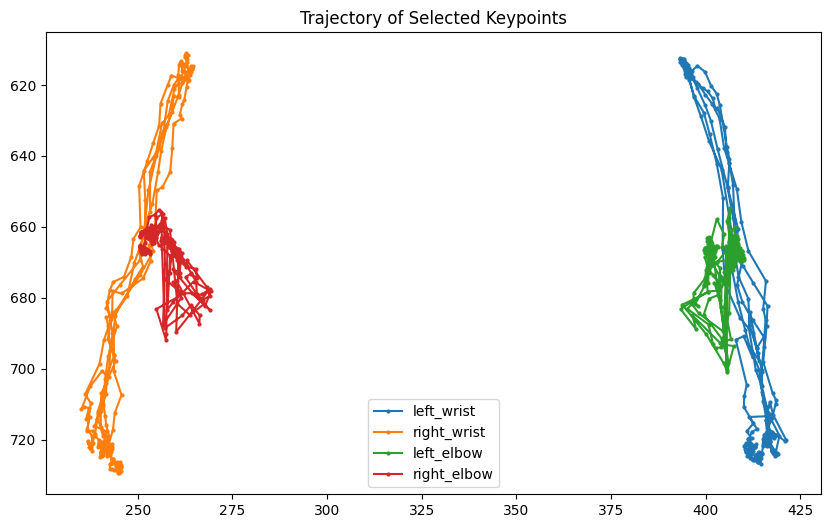

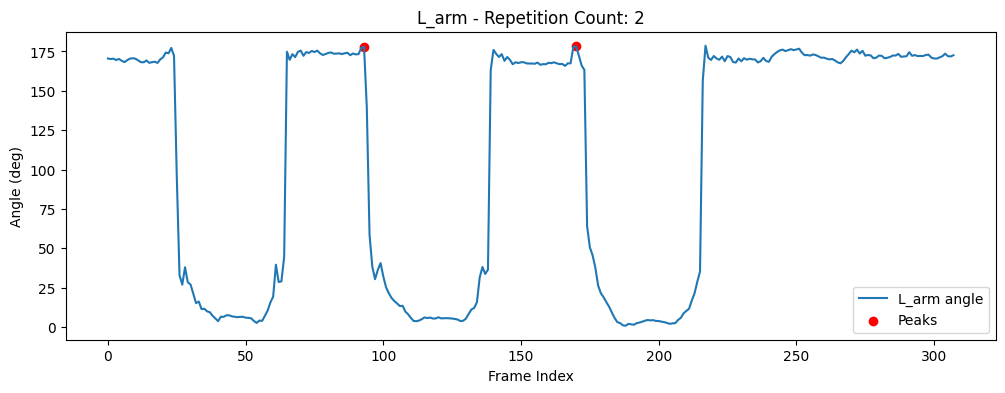

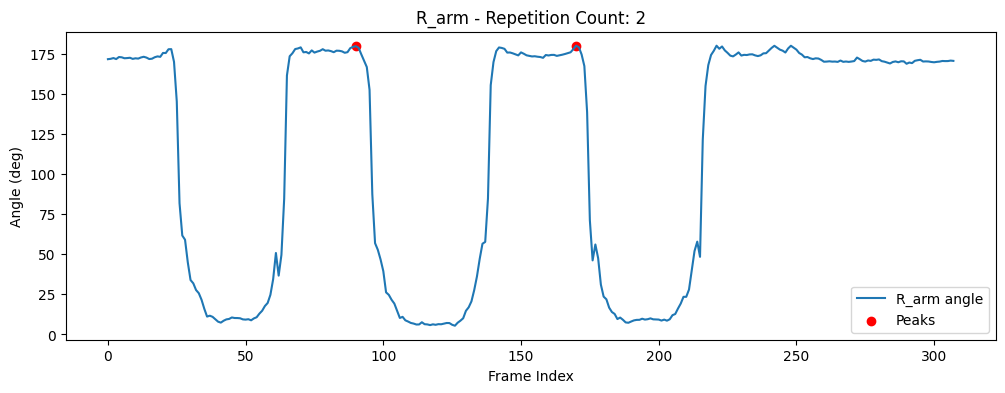

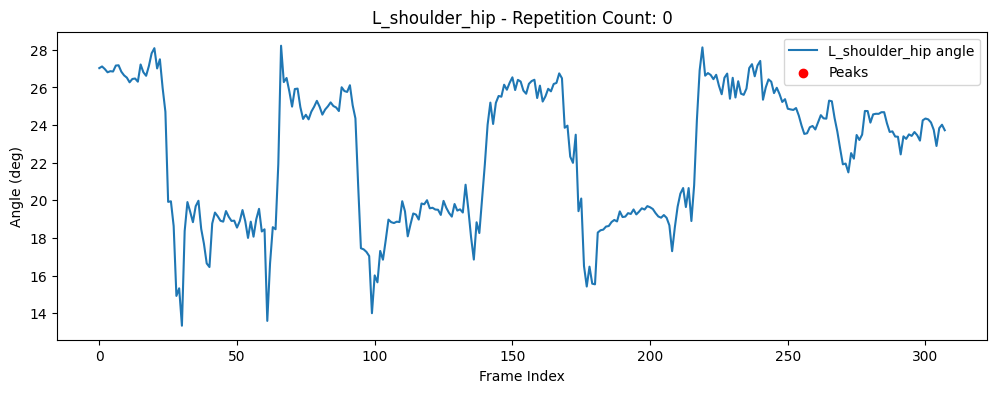

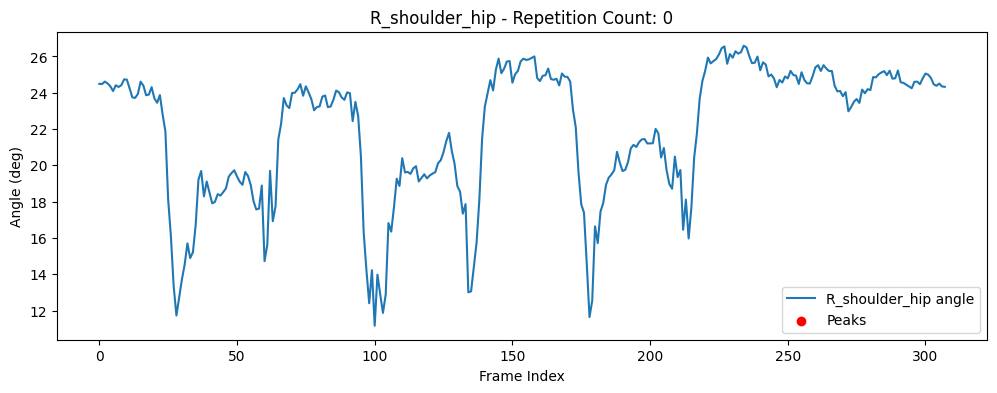

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ---------------------- ÏÑ†ÌÉùÎêú keypoints & angles ----------------------
selected_keypoints = ['left_wrist', 'right_wrist', 'left_elbow', 'right_elbow']
selected_angles = ['L_arm', 'R_arm', 'L_shoulder_hip', 'R_shoulder_hip']

# ---------------------- Keypoint Trajectory ÏãúÍ∞ÅÌôî ----------------------
plt.figure(figsize=(10,6))
for name in selected_keypoints:
    idx = keypoint_indices[name]
    xs, ys = all_keypoints[:, idx, 0], all_keypoints[:, idx, 1]
    plt.plot(xs, ys, marker="o", markersize=2, label=name)
plt.gca().invert_yaxis()
plt.title("Trajectory of Selected Keypoints")
plt.legend()
plt.show()

# ---------------------- Angles Time-Series & Peak Detection ----------------------
for ang_name in selected_angles:
    series = all_angles[ang_name]

    # Peak detection
    peaks, _ = find_peaks(series, prominence=15, distance=10)

    plt.figure(figsize=(12,4))
    plt.plot(series, label=f"{ang_name} angle")
    plt.scatter(peaks, series[peaks], color="red", label="Peaks")
    plt.title(f"{ang_name} - Repetition Count: {len(peaks)}")
    plt.xlabel("Frame Index")
    plt.ylabel("Angle (deg)")
    plt.legend()
    plt.show()


# FFT

## FFT

In [28]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
import numpy as np
import pandas as pd
from pathlib import Path
from math import acos, degrees

# ---------------------- Í≤ΩÎ°ú ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_JSON"
)

OUT_CSV = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/angle_trajectory.csv"
)

fps = 30

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)+1e-6)
    return degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- Ïù∏Îç±Ïä§ Ï†ïÏùò ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
}

angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
}

# ---------------------- Îç∞Ïù¥ÌÑ∞ Ï†ÅÏû¨ ----------------------
json_files = sorted(KP_DIR.glob("*.json"))
all_keypoints = [load_keypoints(f) for f in json_files]
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

# ---------------------- Í∞ÅÎèÑ ÏãúÍ≥ÑÏó¥ ÏÉùÏÑ± ----------------------
all_angles = {name: [] for name in angles_def}
for frame in all_keypoints:
    for name, (i,j,k) in angles_def.items():
        all_angles[name].append(angle_between(frame[i], frame[j], frame[k]))

# DataFrame Î≥ÄÌôò
df = pd.DataFrame({
    "frame": np.arange(len(all_keypoints)),
    "L_arm": all_angles["L_arm"],
    "R_arm": all_angles["R_arm"],
})

# ---------------------- CSV Ï†ÄÏû• ----------------------
df.to_csv(OUT_CSV, index=False)
print(f"‚úÖ Angle trajectory CSV Ï†ÄÏû• ÏôÑÎ£å: {OUT_CSV}")


‚úÖ Angle trajectory CSV Ï†ÄÏû• ÏôÑÎ£å: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/angle_trajectory.csv


In [31]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import numpy as np  # ÏàòÏπò Í≥ÑÏÇ∞ÏùÑ ÏúÑÌï¥ ÎÑòÌååÏù¥Î•º ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
import pandas as pd  # CSV ÌååÏùº Î°úÎìúÎ•º ÏúÑÌï¥ ÌåêÎã§Ïä§Î•º ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
import cv2  # ÏòÅÏÉÅ ÏûÖÏ∂úÎ†•Í≥º Ïò§Î≤ÑÎ†àÏù¥Î•º ÏúÑÌï¥ OpenCVÎ•º ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
from pathlib import Path  # Í≤ΩÎ°ú Ï≤òÎ¶¨Î•º ÏúÑÌï¥ PathÎ•º ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
from tqdm import tqdm  # ÏßÑÌñâÎ•† ÌëúÏãúÎ•º ÏúÑÌï¥ tqdmÏùÑ ÏûÑÌè¨Ìä∏Ìï¥Ïöî.

# SciPyÍ∞Ä ÏûàÏúºÎ©¥ find_peaksÎ•º Ïì∞Í≥† ÏóÜÏúºÎ©¥ Í∞ÑÎã® ÎåÄÏ≤¥ Î°úÏßÅÏùÑ Ïç®Ïöî.
try:
    from scipy.signal import find_peaks  # Ïã†Î¢∞ÎèÑ ÎÜíÏùÄ ÌîºÌÅ¨ ÌÉêÏßÄÎ•º ÏúÑÌï¥ SciPyÏùò find_peaksÎ•º ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
    SCIPY_OK = True  # SciPy ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂ÄÎ•º TrueÎ°ú Í∏∞Î°ùÌï¥Ïöî.
except Exception:
    SCIPY_OK = False  # SciPyÍ∞Ä ÏóÜÏúºÎ©¥ FalseÎ°ú Í∏∞Î°ùÌï¥Ïöî.

# ---------------------- Í≤ΩÎ°ú ÏÑ§Ï†ï ----------------------
FRAME_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/1_FRAME_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_frames"
)  # ÌîÑÎ†àÏûÑ Ïù¥ÎØ∏ÏßÄÎì§Ïù¥ Ï†ÄÏû•Îêú ÎîîÎ†âÌÑ∞Î¶¨ Í≤ΩÎ°úÎ•º ÏßÄÏ†ïÌï¥Ïöî.

CSV_PATH = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/angle_trajectory.csv"
)  # angle_trajectory.csv ÌååÏùº Í≤ΩÎ°úÎ•º ÏßÄÏ†ïÌï¥Ïöî.

OUT_PATH = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/angle_count_overlay.mp4"
)  # Í≤∞Í≥º MP4 ÌååÏùº Ï†ÄÏû• Í≤ΩÎ°úÎ•º ÏßÄÏ†ïÌï¥Ïöî.

FPS = 30  # ÏòÅÏÉÅ ÌîÑÎ†àÏûÑÎ†àÏù¥Ìä∏Î•º 30fpsÎ°ú ÏÑ§Ï†ïÌï¥Ïöî.

# ---------------------- Ïú†Ìã∏: Í∞ÑÎã® Ïù¥ÎèôÌèâÍ∑† Ïä§Î¨¥Îî© ----------------------
def moving_average(x: np.ndarray, win_frames: int) -> np.ndarray:
    win = max(3, int(win_frames) | 1)  # ÌôÄÏàò ÏúàÎèÑÏö∞Î•º Î≥¥Ïû•ÌïòÍ∏∞ ÏúÑÌï¥ ÎπÑÌä∏ ORÎ°ú 1ÏùÑ Í∞ïÏ†úÌï¥Ïöî.
    pad = win // 2  # Í∞ÄÏû•ÏûêÎ¶¨ Ï≤òÎ¶¨Î•º ÏúÑÌïú Ìå®Îî© Í∏∏Ïù¥Î•º Í≥ÑÏÇ∞Ìï¥Ïöî.
    left, right = x[0], x[-1]  # Ïñë ÎÅùÏ†êÏùÑ Î≥µÏ†úÌïòÏó¨ Ìå®Îî©Ïóê ÏÇ¨Ïö©Ìï¥Ïöî.
    padded = np.concatenate([np.full(pad, left), x, np.full(pad, right)])  # ÏñëÎÅù Ìå®Îî©ÏùÑ ÎçßÎ∂ôÏó¨ Í≤ΩÍ≥Ñ ÏôúÍ≥°ÏùÑ Ï§ÑÏó¨Ïöî.
    kernel = np.ones(win) / win  # Í∑†Ïùº Í∞ÄÏ§ëÏπòÏùò Ïù¥ÎèôÌèâÍ∑† Ïª§ÎÑêÏùÑ ÏÉùÏÑ±Ìï¥Ïöî.
    smoothed = np.convolve(padded, kernel, mode="valid")  # Ïª®Î≥ºÎ£®ÏÖòÏúºÎ°ú Ïä§Î¨¥Îî© Í∞íÏùÑ Í≥ÑÏÇ∞Ìï¥Ïöî.
    return smoothed  # Ïä§Î¨¥Îî©Îêú ÏãúÍ≥ÑÏó¥ÏùÑ Î∞òÌôòÌï¥Ïöî.

# ---------------------- Ïú†Ìã∏: SciPy ÎåÄÏ≤¥ ÌîºÌÅ¨ ÌÉêÏßÄÍ∏∞ ----------------------
def simple_find_peaks(x: np.ndarray, distance: int = 1) -> np.ndarray:
    idx = np.where((x[1:-1] > x[:-2]) & (x[1:-1] > x[2:]))[0] + 1  # Ïù¥ÏõÉÎ≥¥Îã§ ÌÅ∞ ÎÇ¥Î∂Ä ÏµúÎåÄÍ∞íÏùò Ïù∏Îç±Ïä§Î•º Ï∞æÏñ¥Ïöî.
    picked = []  # ÏµúÏÜå Í∞ÑÍ≤© Ï°∞Í±¥ÏúºÎ°ú Í±∏Îü¨ÎÇº Ïù∏Îç±Ïä§ Î¶¨Ïä§Ìä∏Î•º ÎßåÎì§Ïñ¥Ïöî.
    last = -10**9  # ÎßàÏßÄÎßâ Ï±ÑÌÉù Ïù∏Îç±Ïä§Î•º Îß§Ïö∞ ÏûëÏùÄ Í∞íÏúºÎ°ú Ï¥àÍ∏∞ÌôîÌï¥Ïöî.
    for i in idx:  # Î™®Îì† ÌõÑÎ≥¥ Ïù∏Îç±Ïä§Î•º ÏàúÌöåÌï¥Ïöî.
        if i - last >= distance:  # ÏµúÏÜå Í∞ÑÍ≤©ÏùÑ ÎßåÏ°±ÌïòÎäî Í≤ΩÏö∞ÏóêÎßå Ï±ÑÌÉùÌï¥Ïöî.
            picked.append(i)  # ÏÑ†ÌÉù Ïù∏Îç±Ïä§Î•º Í≤∞Í≥ºÏóê Ï∂îÍ∞ÄÌï¥Ïöî.
            last = i  # ÎßàÏßÄÎßâ ÏÑ†ÌÉù Ïù∏Îç±Ïä§Î•º Í∞±Ïã†Ìï¥Ïöî.
    return np.array(picked, dtype=int)  # ÎÑòÌååÏù¥ Î∞∞Ïó¥Î°ú Î∞òÌôòÌï¥Ïöî.

# ---------------------- 1) CSV‚ÜíÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏ Í≥ÑÏÇ∞ ----------------------
def cum_count_from_csv(csv_path: Path, fps: int = 30,
                       prefer_valley: bool = True,
                       min_cycle_sec: float = 1.5,
                       smooth_window_sec: float = 0.5) -> np.ndarray:
    df = pd.read_csv(csv_path)  # CSVÎ•º ÏùΩÏñ¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î°úÎìúÌï¥Ïöî.
    assert {"L_arm", "R_arm"}.issubset(df.columns), "CSVÏóê L_arm, R_arm Ïª¨ÎüºÏù¥ ÌïÑÏöîÌï©ÎãàÎã§."  # ÌïÑÏàò Ïª¨ÎüºÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏Ìï¥Ïöî.
    signal_raw = (df["L_arm"].to_numpy() + df["R_arm"].to_numpy()) / 2.0  # Ï¢åÏö∞ Ìåî Í∞ÅÎèÑÎ•º ÌèâÍ∑†ÌïòÏó¨ ÎåÄÌëú Ïã†Ìò∏Î•º ÎßåÎì§Ïñ¥Ïöî.
    smoothed = moving_average(signal_raw, win_frames=int(round(smooth_window_sec * fps)))  # Ïù¥ÎèôÌèâÍ∑†ÏúºÎ°ú Ïã†Ìò∏Î•º Ïä§Î¨¥Îî©Ìï¥Ïöî.
    min_distance = int(min_cycle_sec * fps)  # ÎèôÏûë ÏµúÏÜå Ï£ºÍ∏∞Î°úÎ∂ÄÌÑ∞ ÏµúÏÜå Í∞ÑÍ≤© ÌîÑÎ†àÏûÑ ÏàòÎ•º Í≥ÑÏÇ∞Ìï¥Ïöî.
    if SCIPY_OK:  # SciPy ÏÇ¨Ïö© Í∞ÄÎä• Ïãú Í≥†Í∏â ÌîºÌÅ¨ ÌÉêÏßÄÎ•º ÏÇ¨Ïö©Ìï¥Ïöî.
        from scipy.signal import find_peaks  # ÏßÄÏó≠ Î≤îÏúÑÏóêÏÑú ÏïàÏ†ÑÌïòÍ≤å Ïû¨ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
        prom = float(np.percentile(np.abs(smoothed - np.median(smoothed)), 60))  # Ïã†Ìò∏ Í∑úÎ™® Í∏∞Î∞ò prominence ÏûÑÍ≥ÑÍ∞íÏùÑ Í≥ÑÏÇ∞Ìï¥Ïöî.
        peaks, _ = find_peaks(smoothed, distance=min_distance, prominence=prom)  # ÌîºÌÅ¨Î•º ÌÉêÏßÄÌï¥Ïöî.
        valleys, _ = find_peaks(-smoothed, distance=min_distance, prominence=prom)  # Î∞∏Î¶¨Î•º ÌÉêÏßÄÌï¥Ïöî.
    else:  # SciPyÍ∞Ä ÏóÜÏúºÎ©¥ Îã®Ïàú ÌîºÌÅ¨ ÌÉêÏßÄÍ∏∞Î•º ÏÇ¨Ïö©Ìï¥Ïöî.
        peaks = simple_find_peaks(smoothed, distance=min_distance)  # Í∞ÑÎã® ÌîºÌÅ¨ ÌÉêÏßÄ Í≤∞Í≥ºÎ•º ÏñªÏñ¥Ïöî.
        valleys = simple_find_peaks(-smoothed, distance=min_distance)  # Í∞ÑÎã® Î∞∏Î¶¨ ÌÉêÏßÄ Í≤∞Í≥ºÎ•º ÏñªÏñ¥Ïöî.
    chosen = valleys if prefer_valley else peaks  # ÎèôÏûë Ï†ïÏùòÏóê ÎßûÏ∂∞ Î∞∏Î¶¨ ÎòêÎäî ÌîºÌÅ¨Î•º Í∏∞Ï§ÄÏúºÎ°ú ÏÑ†ÌÉùÌï¥Ïöî.
    cum = np.zeros(len(smoothed), dtype=float)  # ÌîÑÎ†àÏûÑÎ≥Ñ ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Ï†ÄÏû•Ìï† Î∞∞Ïó¥ÏùÑ ÎßåÎì§Ïñ¥Ïöî.
    c = 0  # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º 0ÏúºÎ°ú ÏãúÏûëÌï¥Ïöî.
    chosen_set = set(chosen.tolist())  # Ìè¨Ìï® Í≤ÄÏÇ¨ ÏÜçÎèÑÎ•º ÎÜíÏù¥Í∏∞ ÏúÑÌï¥ ÏßëÌï©ÏúºÎ°ú Î≥ÄÌôòÌï¥Ïöî.
    for i in range(len(smoothed)):  # Ï†ÑÏ≤¥ ÌîÑÎ†àÏûÑÏùÑ ÏàúÌöåÌïòÎ©∞ ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Í≥ÑÏÇ∞Ìï¥Ïöî.
        if i in chosen_set:  # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏù¥ Ïù¥Î≤§Ìä∏ ÌîÑÎ†àÏûÑÏù¥Î©¥ ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Ï¶ùÍ∞ÄÌï¥Ïöî.
            c += 1  # Ïù¥Î≤§Ìä∏Î•º ÎßåÎÇòÎ©¥ Ïπ¥Ïö¥Ìä∏Î•º 1 ÎçîÌï¥Ïöî.
        cum[i] = c  # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Í∏∞Î°ùÌï¥Ïöî.
    return cum  # ÌîÑÎ†àÏûÑÎ≥Ñ ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏ Î∞∞Ïó¥ÏùÑ Î∞òÌôòÌï¥Ïöî.

# ---------------------- 2) ÌîÑÎ†àÏûÑ‚ÜíMP4 Ïò§Î≤ÑÎ†àÏù¥ Ï†ÄÏû• ----------------------
def save_count_overlay_video(frame_dir: Path, counts: np.ndarray,
                             out_path: Path, fps: int = 30) -> None:
    frame_files = sorted(frame_dir.glob("*.jpg")) + sorted(frame_dir.glob("*.jpeg")) + sorted(frame_dir.glob("*.png"))  # ÏßÄÏõê ÌôïÏû•Ïûê ÌååÏùºÏùÑ Î™®Îëê ÏàòÏßëÌï¥Ïöî.
    if not frame_files:  # ÌîÑÎ†àÏûÑÏù¥ ÌïòÎÇòÎèÑ ÏóÜÏúºÎ©¥ ÏóêÎü¨Î•º Î∞úÏÉùÏãúÏºúÏöî.
        raise FileNotFoundError(f"No frame images found in: {frame_dir}")  # ÌîÑÎ†àÏûÑ Í≤ΩÎ°ú Î¨∏Ï†úÎ•º Î™ÖÏãúÏ†ÅÏúºÎ°ú ÏïåÎ†§Ï§òÏöî.
    sample = cv2.imread(str(frame_files[0]))  # Ï≤´ ÌîÑÎ†àÏûÑÏùÑ ÏùΩÏñ¥ ÏòÅÏÉÅ ÌÅ¨Í∏∞Î•º ÌôïÏù∏Ìï¥Ïöî.
    h, w = sample.shape[:2]  # ÏòÅÏÉÅ ÎÜíÏù¥ÏôÄ ÎÑàÎπÑÎ•º Ï∂îÏ∂úÌï¥Ïöî.
    vw = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))  # MP4 ÎùºÏù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï¥Ïöî.
    for f, img_path in enumerate(tqdm(frame_files, desc="Rendering MP4")):  # Ï†ÑÏ≤¥ ÌîÑÎ†àÏûÑÏùÑ ÏàúÌöåÌïòÎ©∞ Î†åÎçîÎßÅÌï¥Ïöî.
        img = cv2.imread(str(img_path))  # ÌîÑÎ†àÏûÑ Ïù¥ÎØ∏ÏßÄÎ•º ÏùΩÏñ¥Ïöî.
        idx = min(f, len(counts) - 1)  # Ïπ¥Ïö¥Ìä∏ Ïù∏Îç±Ïä§Î•º ÌîÑÎ†àÏûÑ Î≤îÏúÑÏóê ÎßûÍ≤å ÌÅ¥Îû®ÌîÑÌï¥Ïöî.
        txt = f"Reps: {int(round(counts[idx]))}"  # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º ÌÖçÏä§Ìä∏Î°ú ÎßåÎì§Ïñ¥Ïöî.
        cv2.putText(img, txt, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)  # ÏòÅÏÉÅ Ï¢åÏÉÅÎã®Ïóê Ïπ¥Ïö¥Ìä∏Î•º Ïò§Î≤ÑÎ†àÏù¥Ìï¥Ïöî.
        vw.write(img)  # Ïò§Î≤ÑÎ†àÏù¥Îêú ÌîÑÎ†àÏûÑÏùÑ ÏòÅÏÉÅÏúºÎ°ú Í∏∞Î°ùÌï¥Ïöî.
    vw.release()  # ÎπÑÎîîÏò§ ÎùºÏù¥ÌÑ∞Î•º Ï†ïÏÉÅ Ï¢ÖÎ£åÌï¥Ïöî.
    print(f"‚úÖ Saved: {out_path}")  # Ï†ÄÏû• ÏôÑÎ£å Î©îÏãúÏßÄÎ•º Ï∂úÎ†•Ìï¥Ïöî.

# ---------------------- Ïã§ÌñâÎ∂Ä ----------------------
if __name__ == "__main__":  # Ïä§ÌÅ¨Î¶ΩÌä∏ ÏßÑÏûÖÏ†êÏùÑ Ï†ïÏùòÌï¥Ïöî.
    assert CSV_PATH.is_file(), f"CSV not found: {CSV_PATH}"  # CSV Í≤ΩÎ°úÍ∞Ä Ïú†Ìö®ÌïúÏßÄ Î®ºÏ†Ä ÌôïÏù∏Ìï¥Ïöî.
    assert FRAME_DIR.is_dir(), f"FRAME_DIR not found: {FRAME_DIR}"  # ÌîÑÎ†àÏûÑ ÎîîÎ†âÌÑ∞Î¶¨Í∞Ä Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏Ìï¥Ïöî.
    counts = cum_count_from_csv(CSV_PATH, fps=FPS, prefer_valley=True, min_cycle_sec=1.5, smooth_window_sec=0.5)  # CSVÎ°úÎ∂ÄÌÑ∞ ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Í≥ÑÏÇ∞Ìï¥Ïöî.
    save_count_overlay_video(FRAME_DIR, counts, OUT_PATH, fps=FPS)  # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º ÌîÑÎ†àÏûÑÏóê Ïò§Î≤ÑÎ†àÏù¥ÌïòÏó¨ MP4Î°ú Ï†ÄÏû•Ìï¥Ïöî.


Rendering MP4: 100% 308/308 [00:05<00:00, 58.42it/s]

‚úÖ Saved: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/angle_count_overlay.mp4


## sliding FFT

‚úÖ Keypoint left_wrist: ÏµúÏ¢Ö repetition count ‚âà 4


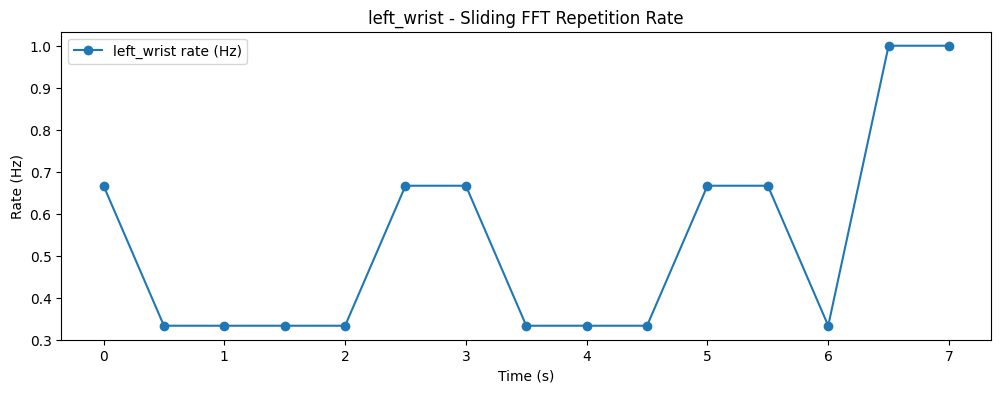

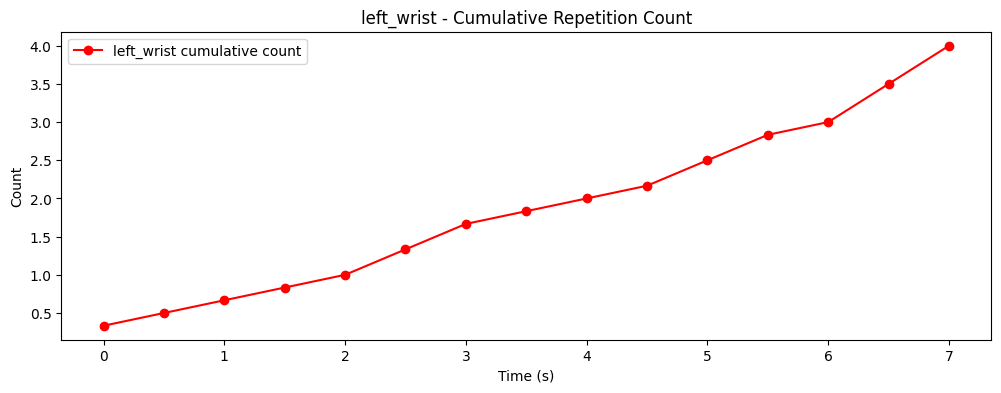

‚úÖ Keypoint right_wrist: ÏµúÏ¢Ö repetition count ‚âà 4


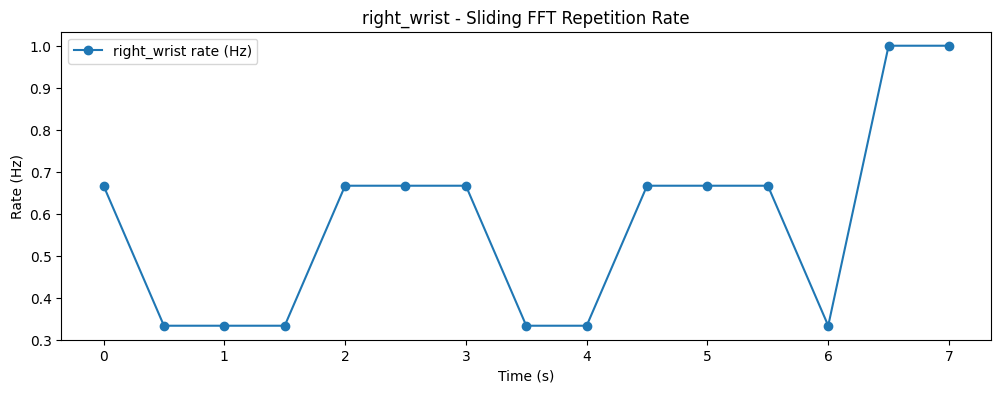

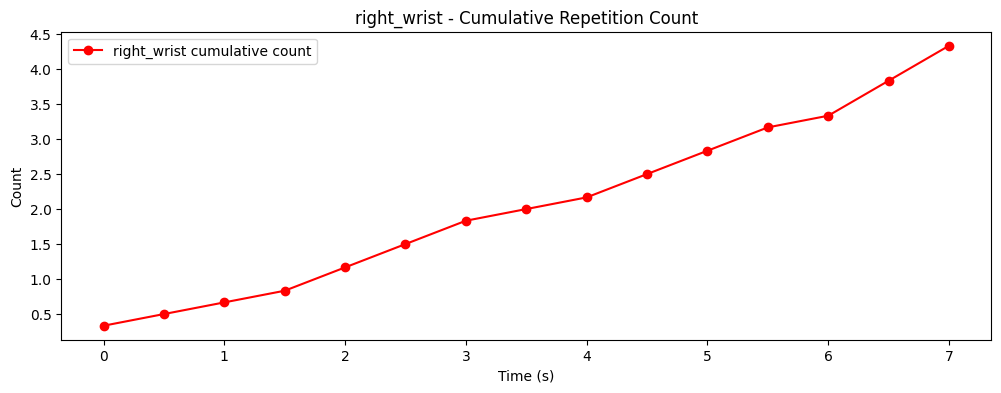

‚úÖ Angle L_arm: ÏµúÏ¢Ö repetition count ‚âà 4


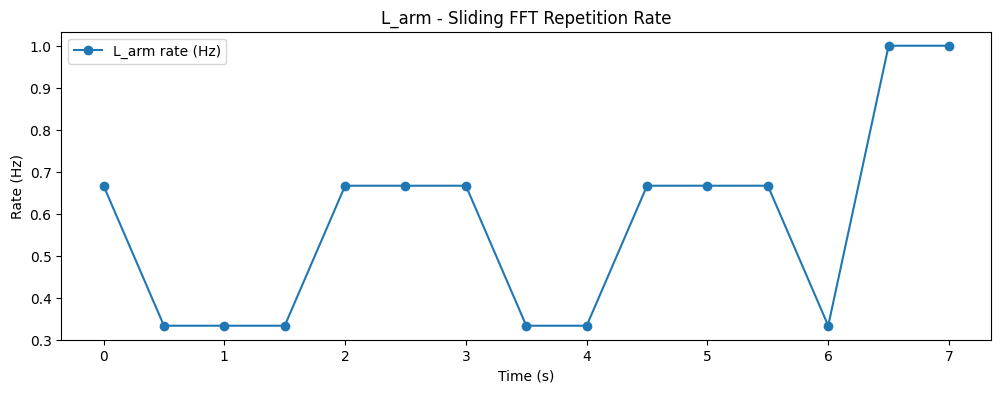

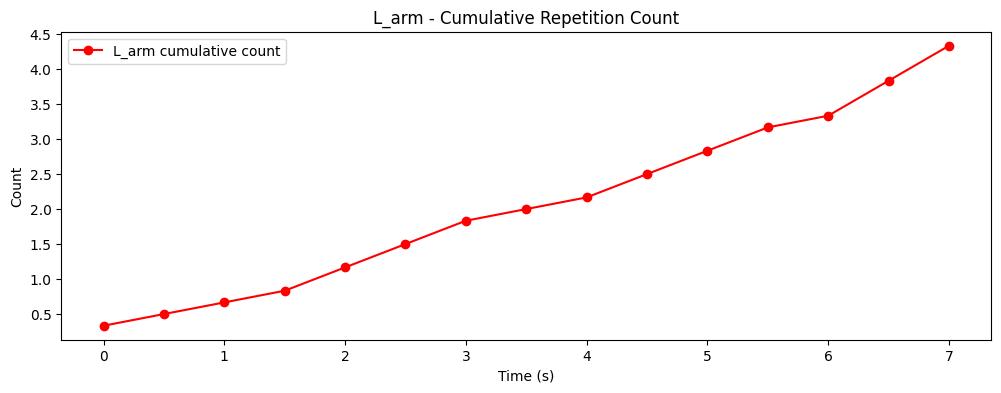

‚úÖ Angle R_arm: ÏµúÏ¢Ö repetition count ‚âà 4


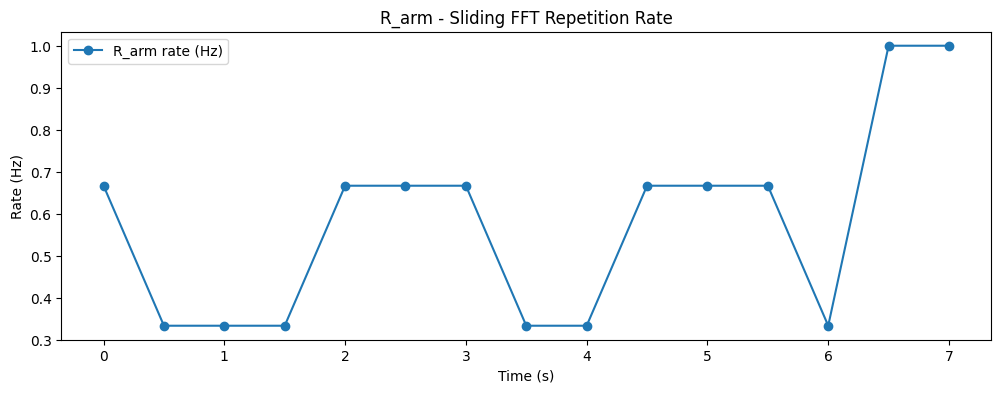

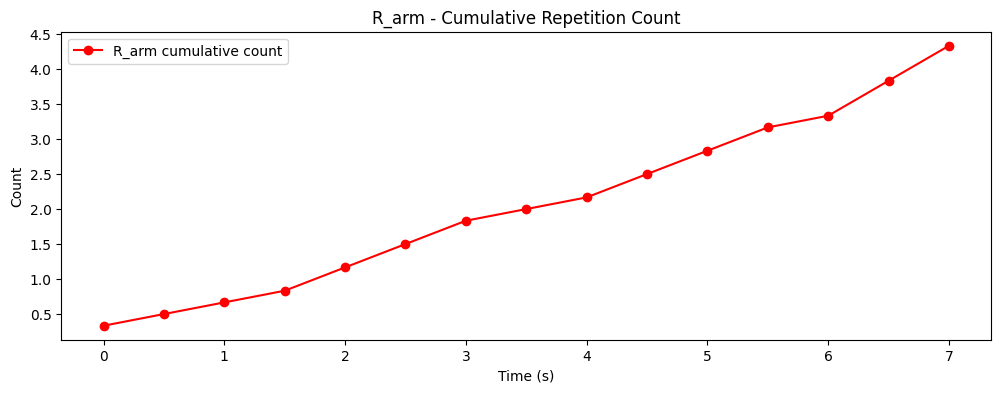

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- FFT Ìï®Ïàò ----------------------
def count_reps_fft(signal, fps=30):
    n = len(signal)
    yf = np.fft.rfft(signal - np.mean(signal))
    xf = np.fft.rfftfreq(n, 1/fps)
    yf_abs = np.abs(yf)
    freq = xf[1:][np.argmax(yf_abs[1:])]
    duration = n / fps
    reps = freq * duration
    return reps, freq

# ---------------------- Sliding Window FFT + ÎàÑÏ†Å Count ----------------------
def sliding_fft_count(signal, fps=30, window_sec=2, step_sec=0.5):
    W = int(window_sec * fps)   # ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞ (ÌîÑÎ†àÏûÑ)
    S = int(step_sec * fps)     # Ïä§ÌÖù ÌÅ¨Í∏∞ (ÌîÑÎ†àÏûÑ)

    n = len(signal)
    rep_estimates = []
    times = []
    cum_count = []

    total_count = 0.0

    for start in range(0, n - W, S):
        window = signal[start:start+W]
        reps, freq = count_reps_fft(window, fps)

        # step_sec ÎèôÏïà Î™á Î≤à Î∞òÎ≥µÌñàÎäîÏßÄ ‚âà rate √ó step_sec
        total_count += freq * step_sec
        rep_estimates.append(freq)
        times.append(start / fps)
        cum_count.append(total_count)

    return np.array(times), np.array(rep_estimates), np.array(cum_count)

# ---------------------- Keypoints (Magnitude) ----------------------
fps = 30
for name in selected_keypoints:
    idx = keypoint_indices[name]
    coords = all_keypoints[:, idx, :]
    mag_series = np.linalg.norm(coords - np.mean(coords, axis=0), axis=1)

    times, rep_rate, cum_count = sliding_fft_count(
        mag_series, fps=fps, window_sec=3, step_sec=0.5
    )

    print(f"‚úÖ Keypoint {name}: ÏµúÏ¢Ö repetition count ‚âà {int(round(cum_count[-1]))}")

    # Repetition Rate ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12,4))
    plt.plot(times, rep_rate, marker="o", label=f"{name} rate (Hz)")
    plt.title(f"{name} - Sliding FFT Repetition Rate")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.legend(); plt.show()

    # ÎàÑÏ†Å Count ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12,4))
    plt.plot(times, cum_count, marker="o", color="red", label=f"{name} cumulative count")
    plt.title(f"{name} - Cumulative Repetition Count")
    plt.xlabel("Time (s)")
    plt.ylabel("Count")
    plt.legend(); plt.show()

# ---------------------- Angles ----------------------
for ang in selected_angles:
    series = all_angles[ang]

    times, rep_rate, cum_count = sliding_fft_count(
        mag_series, fps=fps, window_sec=3, step_sec=0.5
    )

    print(f"‚úÖ Angle {ang}: ÏµúÏ¢Ö repetition count ‚âà {int(round(cum_count[-1]))}")

    # Repetition Rate ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12,4))
    plt.plot(times, rep_rate, marker="o", label=f"{ang} rate (Hz)")
    plt.title(f"{ang} - Sliding FFT Repetition Rate")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.legend(); plt.show()

    # ÎàÑÏ†Å Count ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12,4))
    plt.plot(times, cum_count, marker="o", color="red", label=f"{ang} cumulative count")
    plt.title(f"{ang} - Cumulative Repetition Count")
    plt.xlabel("Time (s)")
    plt.ylabel("Count")
    plt.legend(); plt.show()


In [25]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from math import acos, degrees

# ---------------------- Í≤ΩÎ°ú ----------------------
FRAME_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/1_FRAME_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_frames"
)

KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_JSON"
)

OUT_PATH = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/fft_count_overlay.mp4"
)

fps = 30

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)+1e-6)
    return degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- Ïù∏Îç±Ïä§ Ï†ïÏùò ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

bone_pairs = [
    ("left_shoulder","left_elbow"), ("left_elbow","left_wrist"),
    ("right_shoulder","right_elbow"), ("right_elbow","right_wrist"),
    ("left_hip","left_knee"), ("left_knee","left_ankle"),
    ("right_hip","right_knee"), ("right_knee","right_ankle"),
    ("left_shoulder","left_hip"), ("right_shoulder","right_hip"),
    ("left_shoulder","right_shoulder"), ("left_hip","right_hip")
]

# ---------------------- Îç∞Ïù¥ÌÑ∞ Ï†ÅÏû¨ ----------------------
json_files = sorted(KP_DIR.glob("*.json"))
all_keypoints = [load_keypoints(f) for f in json_files]
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

print(f"‚úÖ Ï¥ù ÌîÑÎ†àÏûÑ Ïàò: {len(all_keypoints)}")


def count_reps_fft(signal, fps=30):
    n = len(signal)                             # Ïã†Ìò∏ Í∏∏Ïù¥ (ÌîÑÎ†àÏûÑ Í∞úÏàò)
    yf = np.fft.rfft(signal - np.mean(signal))  # FFT (ÌèâÍ∑†ÏùÑ ÎπºÏÑú DC ÏÑ±Î∂Ñ Ï†úÍ±∞)
    xf = np.fft.rfftfreq(n, 1/fps)              # Ï£ºÌååÏàò Ï∂ï ÏÉùÏÑ± (0 ~ Nyquist Ï£ºÌååÏàò)
    yf_abs = np.abs(yf)                         # FFT ÌÅ¨Í∏∞ Ïä§ÌéôÌä∏Îüº (ÏßÑÌè≠)
    freq = xf[1:][np.argmax(yf_abs[1:])]        # 0Hz Ï†úÏô∏ ÌõÑ, ÏµúÎåÄ peakÏùò Ï£ºÌååÏàò ÏÑ†ÌÉù
    duration = n / fps                          # Ï†ÑÏ≤¥ Ïã†Ìò∏ Í∏∏Ïù¥(Ï¥à)
    reps = freq * duration                      # Î∞òÎ≥µ ÌöüÏàò = Ï£ºÌååÏàò(Hz) √ó ÏãúÍ∞Ñ(Ï¥à)
    return reps, freq                           # Î∞òÎ≥µ ÌöüÏàò, dominant frequency Î¶¨ÌÑ¥

# ---------------------- FFT Í∏∞Î∞ò Sliding Count ----------------------
def sliding_fft_count(signal, fps=30, window_sec=3.5, step_sec=0.5):
    W = int(window_sec * fps)                   # ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞ (Ï¥à ‚Üí ÌîÑÎ†àÏûÑ Îã®ÏúÑ Î≥ÄÌôò)
    S = int(step_sec * fps)                     # Ïä§ÌÖù ÌÅ¨Í∏∞ (Ï¥à ‚Üí ÌîÑÎ†àÏûÑ Îã®ÏúÑ Î≥ÄÌôò)
    n = len(signal)                             # Ï†ÑÏ≤¥ ÌîÑÎ†àÏûÑ Ïàò
    cum_count = np.zeros(n)                     # ÌîÑÎ†àÏûÑÎ≥Ñ ÎàÑÏ†Å count Ï†ÄÏû•Ïö© Î∞∞Ïó¥
    total_count = 0.0                           # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏ Ï¥àÍ∏∞Ìôî

    for start in range(0, n - W, S):                # ÏãúÏûë ÌîÑÎ†àÏûÑÎ∂ÄÌÑ∞ ÎÅùÍπåÏßÄ S Í∞ÑÍ≤©ÏúºÎ°ú ÏúàÎèÑÏö∞ Ïù¥Îèô
        window = signal[start:start+W]              # ÌòÑÏû¨ Íµ¨Í∞ÑÏùò Ïã†Ìò∏ Ï∂îÏ∂ú
        reps, freq = count_reps_fft(window, fps)    # ÌòÑÏû¨ ÏúàÎèÑÏö∞ÏóêÏÑú Î∞òÎ≥µ ÌöüÏàòÏôÄ Ï£ºÌååÏàò Í≥ÑÏÇ∞
        step_count = freq * step_sec                # Ïù¥Î≤à stepÏóêÏÑú Ï¶ùÍ∞ÄÌï† count = freq √ó step Í∏∏Ïù¥(Ï¥à)
        total_count += step_count                   # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏ Í∞±Ïã†
        cum_count[start:start+S] = total_count      # Ìï¥Îãπ step Íµ¨Í∞ÑÏóê ÎàÑÏ†Å count Í∏∞Î°ù

    if np.any(cum_count == 0):                      # ÏïÑÏßÅ Í∞íÏù¥ ÏóÜÎäî ÌîÑÎ†àÏûÑÏùÄ ÎßàÏßÄÎßâ total_countÎ°ú Ï±ÑÏõÄ
        cum_count[cum_count == 0] = total_count

    return cum_count                                # ÌîÑÎ†àÏûÑÎ≥Ñ ÎàÑÏ†Å repetition count Î∞òÌôò


# ---------------------- Î∂ÑÏÑùÏö© keypoint ÏÑ†ÌÉù (Ïòà: left_wrist) ----------------------
idx = keypoint_indices["left_wrist"]
coords = all_keypoints[:, idx, :]
mag_series = np.linalg.norm(coords - np.mean(coords, axis=0), axis=1)

counts = sliding_fft_count(mag_series, fps=fps, window_sec=3, step_sec=0.5)
print(f"‚úÖ ÏµúÏ¢Ö repetition count ‚âà {int(round(counts[-1]))}")

# ---------------------- Overlay Video ÏÉùÏÑ± ----------------------
def save_overlay_video(frame_dir, keypoints, counts, out_path, fps=30):
    frame_files = sorted(frame_dir.glob("*.jpg")) \
               + sorted(frame_dir.glob("*.jpeg")) \
               + sorted(frame_dir.glob("*.png"))

    if not frame_files:
        raise FileNotFoundError(f"‚ùå No frame images found in {frame_dir}")

    sample = cv2.imread(str(frame_files[0]))
    h, w, _ = sample.shape
    writer = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

    for f, frame_file in enumerate(tqdm(frame_files, desc="Rendering video")):
        img = cv2.imread(str(frame_file))

        # count overlay
        count_txt = f"Reps: {int(round(counts[min(f, len(counts)-1)]))}"
        cv2.putText(img, count_txt, (50, 80), cv2.FONT_HERSHEY_SIMPLEX,
                    2, (0,0,255), 4, cv2.LINE_AA)

        # skeleton overlay
        pts = keypoints[f].astype(int)
        for (a,b) in bone_pairs:
            ia, ib = keypoint_indices[a], keypoint_indices[b]
            cv2.line(img, tuple(pts[ia]), tuple(pts[ib]), (0,255,0), 2)
        for (name, idx) in keypoint_indices.items():
            cv2.circle(img, tuple(pts[idx]), 4, (0,0,255), -1)

        writer.write(img)

    writer.release()
    print(f"‚úÖ Overlay ÏòÅÏÉÅ Ï†ÄÏû• ÏôÑÎ£å: {out_path}")

# Ïã§Ìñâ
save_overlay_video(FRAME_DIR, all_keypoints, counts, out_path=OUT_PATH, fps=fps)


‚úÖ Ï¥ù ÌîÑÎ†àÏûÑ Ïàò: 308
‚úÖ ÏµúÏ¢Ö repetition count ‚âà 4


Rendering video: 100% 308/308 [00:05<00:00, 57.07it/s]

‚úÖ Overlay ÏòÅÏÉÅ Ï†ÄÏû• ÏôÑÎ£å: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/fft_count_overlay.mp4


# Threshold_based count Î∞©Ïãù (Top, Mid, Bot) 

‚úÖ ÏµúÏ¢Ö Ïπ¥Ïö¥Ìä∏: 3


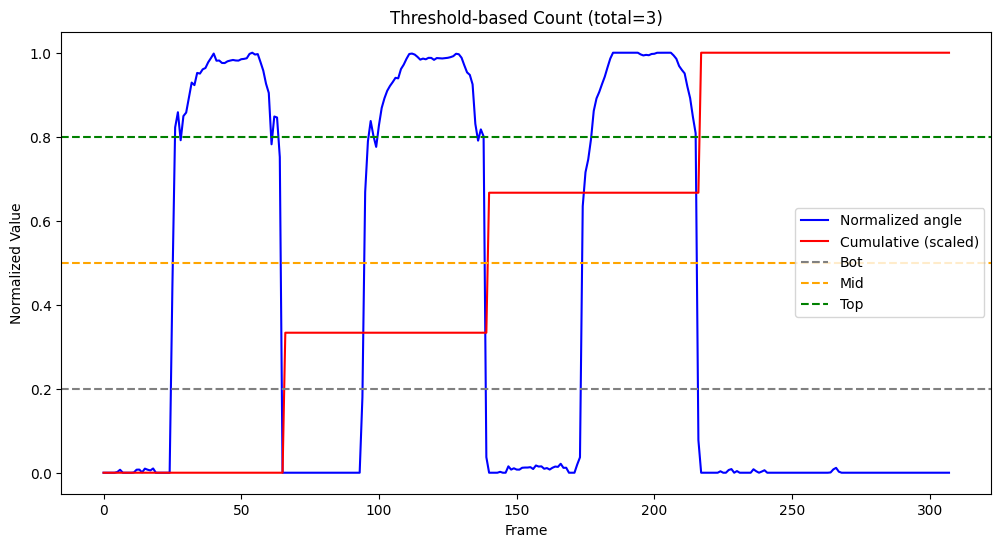

In [33]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# ---------------------- ÎùºÏù¥Î∏åÎü¨Î¶¨ ----------------------
import json  # JSON ÌååÏùº Î°úÎìúÎ•º ÏúÑÌï¥ ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
from pathlib import Path  # Í≤ΩÎ°ú Í¥ÄÎ¶¨Î•º ÏúÑÌï¥ ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
import numpy as np  # ÏàòÏπò Í≥ÑÏÇ∞ÏùÑ ÏúÑÌï¥ ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
import matplotlib.pyplot as plt  # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÏûÑÌè¨Ìä∏Ìï¥Ïöî.
from math import acos, degrees  # Í∞ÅÎèÑ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌï¥ ÏûÑÌè¨Ìä∏Ìï¥Ïöî.

# ---------------------- Í≤ΩÎ°ú ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_JSON"
)  # JSON ÌÇ§Ìè¨Ïù∏Ìä∏Í∞Ä Ï†ÄÏû•Îêú Ìè¥Îçî Í≤ΩÎ°ú


FPS = 30  # Ï¥àÎãπ ÌîÑÎ†àÏûÑ ÏàòÎ•º ÏßÄÏ†ïÌï¥Ïöî.
BASELINE_FRAMES = 30  # Í∏∞Ï§ÄÏÑ† Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú ÌîÑÎ†àÏûÑ ÏàòÎ•º ÏßÄÏ†ïÌï¥Ïöî.

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:  # JSON ÌååÏùºÏùÑ Ïó¥Ïñ¥Ïöî.
        data = json.load(f)  # JSONÏùÑ ÌååÏã±Ìï¥Ïöî.
    return np.array(data["instance_info"][0]["keypoints"], dtype=float)  # ÌÇ§Ìè¨Ïù∏Ìä∏ Î∞∞Ïó¥ÏùÑ Î∞òÌôòÌï¥Ïöî.

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2  # Î≤°ÌÑ∞Î•º Í≥ÑÏÇ∞Ìï¥Ïöî.
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)  # 0 ÎÇòÎàî Î∞©ÏßÄÏö© ÏûëÏùÄ Í∞íÏùÑ ÎçîÌï¥Ïöî.
    cosang = np.dot(v1, v2) / denom  # ÏΩîÏÇ¨Ïù∏ÏùÑ Í≥ÑÏÇ∞Ìï¥Ïöî.
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))  # ÎèÑ Îã®ÏúÑ Í∞ÅÎèÑÎ•º Î∞òÌôòÌï¥Ïöî.

# ---------------------- ÌÇ§Ìè¨Ïù∏Ìä∏ Ïù∏Îç±Ïä§ ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16,
}  # COCO Ï≤¥Í≥ÑÏóê ÎßûÎäî 17Í∞ú Í¥ÄÏ†à Ïù∏Îç±Ïä§ÏòàÏöî.

# ---------------------- 8Í∞ú Í¥ÄÏ†àÍ∞Å Ï†ïÏùò ----------------------
angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- Í∞ÅÎèÑ Í≥ÑÏÇ∞ ----------------------
def compute_all_angles(all_keypoints, angles_def):
    angles = {k: [] for k in angles_def.keys()}  # Í∞ÅÎèÑ Í≤∞Í≥º Ï†ÄÏû• ÎîïÏÖîÎÑàÎ¶¨Î•º ÎßåÎì§Ïñ¥Ïöî.
    for frame in all_keypoints:  # Í∞Å ÌîÑÎ†àÏûÑÏùÑ ÏàúÌöåÌï¥Ïöî.
        for name, (i, j, k) in angles_def.items():  # Í∞ÅÎèÑ Ï†ïÏùòÎ•º Í∫ºÎÇ¥Ïöî.
            ang = angle_between(frame[i], frame[j], frame[k])  # Í∞ÅÎèÑÎ•º Í≥ÑÏÇ∞Ìï¥Ïöî.
            angles[name].append(ang)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•Ìï¥Ïöî.
    return {k: np.asarray(v) for k, v in angles.items()}  # Î∞∞Ïó¥Î°ú Î∞òÌôòÌï¥Ïöî.

# ---------------------- Í∞ÅÎèÑ Î∞©Ìñ• ÌÜµÏùº ----------------------
def unify_direction(angles):
    ext180 = {"L_arm", "R_arm", "L_leg", "R_leg"}  # 180¬∞Í∞Ä Í∏∞Î≥∏Ïù∏ Í∞ÅÎèÑÎì§.
    base0 = {"L_shoulder_hip", "R_shoulder_hip", "L_hip", "R_hip"}  # 0¬∞Í∞Ä Í∏∞Î≥∏Ïù∏ Í∞ÅÎèÑÎì§.
    unified = {}  # ÌÜµÏùº Í≤∞Í≥ºÎ•º Îã¥ÏùÑ ÎîïÏÖîÎÑàÎ¶¨.
    for name, series in angles.items():  # Í∞ÅÎèÑÎ≥ÑÎ°ú ÏàúÌöåÌï¥Ïöî.
        if name in ext180:  # 180¬∞ Í∏∞Ï§ÄÏù¥Î©¥
            unified[name] = 180 - series  # Íµ¥Í≥°‚Üë ‚áí Í∞í‚ÜëÎ°ú Î≥ÄÌôòÌï¥Ïöî.
        else:  # 0¬∞ Í∏∞Ï§ÄÏù¥Î©¥
            unified[name] = series  # Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï¥Ïöî.
    return unified

# ---------------------- Í∏∞Ï§ÄÏÑ† Î≥¥Ï†ï + 0~1 Ï†ïÍ∑úÌôî ----------------------
def normalize_series(series, baseline_frames=30):
    base = np.median(series[:baseline_frames])  # Ï¥àÍ∏∞ Í∏∞Ï§ÄÏÑ†ÏùÑ Í≥ÑÏÇ∞Ìï¥Ïöî.
    zeroed = np.maximum(0, series - base)  # Í∏∞Ï§ÄÏÑ† ÏïÑÎûòÎäî 0ÏúºÎ°ú ÌÅ¥Î¶¨ÌïëÌï¥Ïöî.
    lo, hi = np.percentile(zeroed, [5, 95])  # Î∂ÑÏúÑÏàòÎ•º Íµ¨Ìï¥Ïöî.
    scale = max(hi - lo, 1e-6)  # Î∂ÑÎ™®Í∞Ä 0Ïù¥ ÎêòÏßÄ ÏïäÍ≤å Ìï¥Ïöî.
    unit = np.clip((zeroed - lo) / scale, 0, 1)  # 0~1Î°ú Ï†ïÍ∑úÌôîÌï¥Ïöî.
    return unit

# ---------------------- Threshold ÏÉÅÌÉúÎ®∏Ïã† ----------------------
def count_threshold(sig, fps=30, bot=0.2, mid=0.5, top=0.8, min_interval=1.5):
    n = len(sig)  # ÌîÑÎ†àÏûÑ ÏàòÎ•º Í∞ÄÏ†∏ÏôÄÏöî.
    cum = np.zeros(n)  # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Ï†ÄÏû•Ìï† Î∞∞Ïó¥Ïù¥ÏóêÏöî.
    cnt = 0  # Ïπ¥Ïö¥Ìä∏ ÏãúÏûëÍ∞íÏùÄ 0Ïù¥ÏóêÏöî.
    state = "idle"  # Ï¥àÍ∏∞ ÏÉÅÌÉúÎäî idleÏù¥ÏóêÏöî.
    last_count = -1e9  # ÎßàÏßÄÎßâ Ïπ¥Ïö¥Ìä∏ ÌîÑÎ†àÏûÑÏùÑ Î®º Í≥ºÍ±∞Î°ú Îë¨Ïöî.
    min_gap = int(min_interval * fps)  # ÏµúÏÜå Í∞ÑÍ≤©ÏùÑ ÌîÑÎ†àÏûÑÏúºÎ°ú ÌôòÏÇ∞Ìï¥Ïöî.

    for i, v in enumerate(sig):  # Î™®Îì† ÌîÑÎ†àÏûÑÏùÑ ÏàúÌöåÌï¥Ïöî.
        if state == "idle" and v >= mid:  # Mid Ïù¥ÏÉÅ Ïò¨ÎùºÍ∞ÄÎ©¥ rising ÏÉÅÌÉúÎ°ú Ï†ÑÌôòÌï¥Ïöî.
            state = "rising"
        elif state == "rising" and v >= top:  # Top Ïù¥ÏÉÅÏù¥Î©¥ top ÏÉÅÌÉúÎ°ú Ï†ÑÌôòÌï¥Ïöî.
            state = "top"
        elif state == "top" and v <= mid:  # Îã§Ïãú Mid ÏïÑÎûòÎ°ú ÎÇ¥Î†§Ïò§Î©¥ falling ÏÉÅÌÉúÏòàÏöî.
            state = "falling"
        elif state == "falling" and v <= bot:  # BotÍπåÏßÄ ÎÇ¥Î†§Ïò§Î©¥ ÎèôÏûë 1ÌöåÎ°ú Ïπ¥Ïö¥Ìä∏Ìï¥Ïöî.
            if i - last_count >= min_gap:  # ÏµúÏÜå Í∞ÑÍ≤© Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎ©¥
                cnt += 1  # Ïπ¥Ïö¥Ìä∏Î•º 1 Ï¶ùÍ∞ÄÌï¥Ïöî.
                last_count = i  # ÎßàÏßÄÎßâ Ïπ¥Ïö¥Ìä∏ ÏãúÏ†êÏùÑ Í∞±Ïã†Ìï¥Ïöî.
            state = "idle"  # ÏÉÅÌÉúÎ•º idleÎ°ú Ï¥àÍ∏∞ÌôîÌï¥Ïöî.
        cum[i] = cnt  # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º Í∏∞Î°ùÌï¥Ïöî.
    return cum, cnt  # ÌîÑÎ†àÏûÑÎ≥Ñ ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏ÏôÄ Ï¥ù Ïπ¥Ïö¥Ìä∏Î•º Î∞òÌôòÌï¥Ïöî.

# ---------------------- Ïã§Ìñâ ----------------------
if __name__ == "__main__":
    json_files = sorted(KP_DIR.glob("*.json"))  # JSON ÌååÏùºÎì§ÏùÑ Ï†ïÎ†¨Ìï¥Ïöî.
    keypoints = np.array([load_keypoints(f) for f in json_files])  # Î™®Îì† ÌîÑÎ†àÏûÑ ÌÇ§Ìè¨Ïù∏Ìä∏Î•º Î°úÎìúÌï¥Ïöî.
    angles_raw = compute_all_angles(keypoints, angles_def)  # 8Í∞ú Í¥ÄÏ†àÍ∞ÅÏùÑ Í≥ÑÏÇ∞Ìï¥Ïöî.
    angles_uni = unify_direction(angles_raw)  # Í∞ÅÎèÑÎ•º Íµ¥Í≥°‚Üë ‚áí Í∞í‚Üë Î∞©Ìñ•ÏúºÎ°ú ÌÜµÏùºÌï¥Ïöî.

    # ÏòàÏãú: L_armÏùÑ ÏÇ¨Ïö© (ÏûêÎèô ÏÑ†ÌÉù Î°úÏßÅ ÎÑ£ÏùÑ ÏàòÎèÑ ÏûàÏùå)
    series = normalize_series(angles_uni["L_arm"], baseline_frames=BASELINE_FRAMES)  # Ï†ïÍ∑úÌôîÌï¥Ïöî.
    cum, total = count_threshold(series, fps=FPS)  # Threshold Í∏∞Î∞ò Ïπ¥Ïö¥Ìä∏Î•º Ìï¥Ïöî.

    print(f"‚úÖ ÏµúÏ¢Ö Ïπ¥Ïö¥Ìä∏: {total}")  # ÏµúÏ¢Ö Ïπ¥Ïö¥Ìä∏Î•º Ï∂úÎ†•Ìï¥Ïöî.

    # ---------------------- ÏãúÍ∞ÅÌôî ----------------------
    plt.figure(figsize=(12,6))  # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞Î•º ÏßÄÏ†ïÌï¥Ïöî.
    plt.plot(series, label="Normalized angle", color="blue")  # Ï†ïÍ∑úÌôîÎêú Í∞ÅÎèÑÎ•º Í∑∏Î†§Ïöî.
    plt.plot(cum / max(cum.max(), 1), label="Cumulative (scaled)", color="red")  # ÎàÑÏ†Å Ïπ¥Ïö¥Ìä∏Î•º 0~1Î°ú Ïä§ÏºÄÏùºÌï¥ Í∞ôÏù¥ Í∑∏Î†§Ïöî.
    plt.axhline(0.2, color="gray", linestyle="--", label="Bot")  # Bot ÏûÑÍ≥ÑÏÑ†ÏùÑ Í∑∏Î†§Ïöî.
    plt.axhline(0.5, color="orange", linestyle="--", label="Mid")  # Mid ÏûÑÍ≥ÑÏÑ†ÏùÑ Í∑∏Î†§Ïöî.
    plt.axhline(0.8, color="green", linestyle="--", label="Top")  # Top ÏûÑÍ≥ÑÏÑ†ÏùÑ Í∑∏Î†§Ïöî.
    plt.legend()  # Î≤îÎ°ÄÎ•º ÌëúÏãúÌï¥Ïöî.
    plt.title(f"Threshold-based Count (total={total})")  # Í∑∏ÎûòÌîÑ Ï†úÎ™©ÏùÑ ÎÑ£Ïñ¥Ïöî.
    plt.xlabel("Frame")  # xÏ∂ï ÎùºÎ≤®ÏùÑ ÎÑ£Ïñ¥Ïöî.
    plt.ylabel("Normalized Value")  # yÏ∂ï ÎùºÎ≤®ÏùÑ ÎÑ£Ïñ¥Ïöî.
    plt.show()  # Í∑∏ÎûòÌîÑÎ•º Ï∂úÎ†•Ìï¥Ïöî.


üìå ÌõÑÎ≥¥ ÏßÑÌè≠ Ï†êÏàò: {'L_arm': 177.83237701571466, 'R_arm': 174.53964245156737, 'L_shoulder_hip': 14.888354763322743, 'R_shoulder_hip': 15.423712294696353, 'L_leg': 4.124132124161889, 'R_leg': 5.320894181118035, 'L_hip': 4.2487235721376635, 'R_hip': 6.6119425050763425}
‚úÖ ÏÑ†ÌÉùÎêú angle: L_arm
‚úÖ Auto Thresholds ‚Üí Bot=44.10, Mid=115.23, Top=150.80
‚úÖ ÏµúÏ¢Ö Ïπ¥Ïö¥Ìä∏: 3


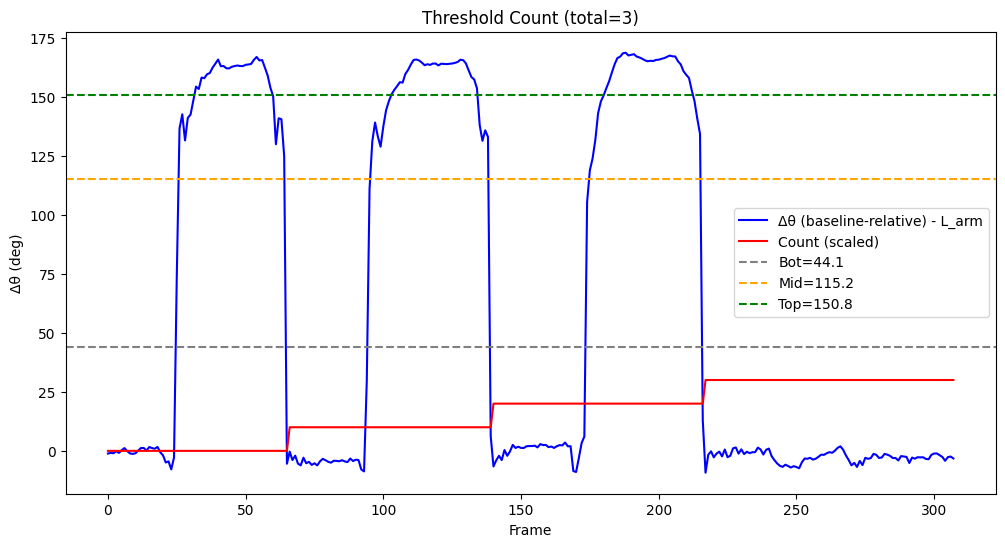

In [45]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from math import acos, degrees

# ---------------------- Í≤ΩÎ°ú ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_ÏïâÏïÑÏÑú ÏñëÏÜê Î¨ºÌÜµ Ïû°Í≥† ÏòÜÏúºÎ°ú Ìåî Ïò¨Î¶¨Í∏∞ 2_JSON"
)  # JSON ÌÇ§Ìè¨Ïù∏Ìä∏Í∞Ä Ï†ÄÏû•Îêú Ìè¥Îçî Í≤ΩÎ°ú



FPS = 30
BASELINE_FRAMES = 30
MIN_INTERVAL_SEC = 1.5  # Ïó∞ÏÜç Ïπ¥Ïö¥Ìä∏ Î∞©ÏßÄ ÏµúÏÜå Í∞ÑÍ≤©

# ---------------------- Ïú†Ìã∏ Ìï®Ïàò ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"], dtype=float)

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    cosang = np.dot(v1, v2) / denom
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- ÌÇ§Ìè¨Ïù∏Ìä∏ Ïù∏Îç±Ïä§ ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16,
}

# ---------------------- 8Í∞ú Í∞ÅÎèÑ Ï†ïÏùò ----------------------
angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- Í¥ÄÏ†àÍ∞Å Í≥ÑÏÇ∞ ----------------------
def compute_all_angles(all_keypoints, angles_def):
    angles = {k: [] for k in angles_def.keys()}
    for frame in all_keypoints:
        for name, (i, j, k) in angles_def.items():
            ang = angle_between(frame[i], frame[j], frame[k])
            angles[name].append(ang)
    return {k: np.asarray(v) for k, v in angles.items()}

# ---------------------- Î∞©Ìñ• ÌÜµÏùº ----------------------
def unify_direction(angles):
    ext180 = {"L_arm", "R_arm", "L_leg", "R_leg"}  # Í∏∞Î≥∏ 180¬∞
    unified = {}
    for name, series in angles.items():
        if name in ext180:
            unified[name] = 180 - series  # Ìé¥ÏßàÏàòÎ°ù 0, ÍµΩÌûêÏàòÎ°ù ‚Üë
        else:
            unified[name] = series  # Í∏∞Î≥∏ 0¬∞ ‚Üí Í∑∏ÎåÄÎ°ú
    return unified

# ---------------------- baseline-relative ----------------------
def baseline_relative(series, baseline_frames=30):
    baseline = np.median(series[:min(len(series), baseline_frames)])
    return series - baseline

# ---------------------- range Í∏∞Î∞ò threshold ----------------------
def auto_thresholds_range(dtheta, bot_ratio=0.3, mid_ratio=0.7, top_ratio=0.9):
    lo, hi = np.min(dtheta), np.max(dtheta)
    amp = hi - lo
    bot = lo + bot_ratio * amp
    mid = lo + mid_ratio * amp
    top = lo + top_ratio * amp
    return bot, mid, top

# ---------------------- ÏÉÅÌÉúÎ®∏Ïã† ----------------------
def count_threshold(dtheta, fps=30, bot=15, mid=30, top=50, min_interval=1.5):
    n = len(dtheta)
    cum = np.zeros(n)
    cnt = 0
    state = "idle"
    last_count = -1e9
    min_gap = int(min_interval * fps)

    for i, v in enumerate(dtheta):
        if state == "idle" and v >= mid:
            state = "rising"
        elif state == "rising" and v >= top:
            state = "top"
        elif state == "top" and v <= mid:
            state = "falling"
        elif state == "falling" and v <= bot:
            if i - last_count >= min_gap:
                cnt += 1
                last_count = i
            state = "idle"
        cum[i] = cnt
    return cum, cnt

# ---------------------- Ïã§Ìñâ ----------------------
if __name__ == "__main__":
    # 1. keypoints Î°úÎìú
    json_files = sorted(KP_DIR.glob("*.json"))
    keypoints = np.array([load_keypoints(f) for f in json_files])

    # 2. Í¥ÄÏ†àÍ∞Å Í≥ÑÏÇ∞ + Î∞©Ìñ• ÌÜµÏùº
    angles_raw = compute_all_angles(keypoints, angles_def)
    angles_uni = unify_direction(angles_raw)

    # 3. Í∞ÄÏû• ÌÅ¨Í≤å ÏõÄÏßÅÏù¥Îäî angle ÏÑ†ÌÉù
    scores = {k: np.ptp(baseline_relative(v)) for k, v in angles_uni.items()}
    best_angle = max(scores.items(), key=lambda x: x[1])[0]
    print("üìå ÌõÑÎ≥¥ ÏßÑÌè≠ Ï†êÏàò:", scores)
    print("‚úÖ ÏÑ†ÌÉùÎêú angle:", best_angle)

    # 4. baseline-relative ŒîŒ∏
    dtheta = baseline_relative(angles_uni[best_angle], baseline_frames=BASELINE_FRAMES)

    # 5. range Í∏∞Î∞ò threshold
    bot, mid, top = auto_thresholds_range(dtheta)
    print(f"‚úÖ Auto Thresholds ‚Üí Bot={bot:.2f}, Mid={mid:.2f}, Top={top:.2f}")

    # 6. Ïπ¥Ïö¥ÌåÖ
    cum, total = count_threshold(dtheta, fps=FPS, bot=bot, mid=mid, top=top,
                                 min_interval=MIN_INTERVAL_SEC)
    print(f"‚úÖ ÏµúÏ¢Ö Ïπ¥Ïö¥Ìä∏: {total}")

    # 7. ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12,6))
    plt.plot(dtheta, label=f"ŒîŒ∏ (baseline-relative) - {best_angle}", color="blue")
    plt.plot(cum * 10, label="Count (scaled)", color="red")  # count Î≥¥Í∏∞ ÏâΩÍ≤å
    plt.axhline(bot, color="gray", linestyle="--", label=f"Bot={bot:.1f}")
    plt.axhline(mid, color="orange", linestyle="--", label=f"Mid={mid:.1f}")
    plt.axhline(top, color="green", linestyle="--", label=f"Top={top:.1f}")
    plt.legend()
    plt.title(f"Threshold Count (total={total})")
    plt.xlabel("Frame")
    plt.ylabel("ŒîŒ∏ (deg)")
    plt.show()
